In [1]:
import numpy as np
import pandas as pd
import MeCab
import re
import json
from collections import Counter
import pickle
import matplotlib.pyplot as plt

import dependency_parsing as dp

plt.rcParams['font.family'] = 'IPAGothic'

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item) is not 0]

In [3]:
with open("../data/compound_train.json") as f:
    train = json.load(f)

In [4]:
train_sentence = pd.read_csv("../data/train_Youto_sentence_and_heading.csv", dtype={"_id": str})
train_sentence = train_sentence.loc[train_sentence.label == 1]
train_sentence.head()

,_id,sentence,label,heading
7,1385415,脂入りはんだのフラックスの主要成分である[1]ほか、ラッカー、ワニス、石鹸や樹脂酸金属塩の製...,1,NO_SUBTITLE
14,3430792,イソプロピルアンチピリン（Isopropylantipyrine）、別名、プロピフェナゾン（...,1,副作用
15,3430792,日本では配合用の原末が医療用に販売されているほか、第2類医薬品として市販の風邪薬に配合されている。,1,副作用
16,3430792,WHOのコメントから抜粋： “ピラゾロン系の解熱鎮痛消炎薬であるイソプロピルアンチピリンは1...,1,副作用
26,3420219,ケトチフェン（Ketotifen）は第二世代の非競合的H1ヒスタミン受容体遮断薬で肥満細胞安...,1,効能・効果


In [5]:
Youto_list = flatten([article['Attributes']['用途'] for article in train['entry']])
Youto_list = [youto.replace('（', '(').replace('）', ')') for youto in Youto_list]

In [6]:
Youto_df = pd.DataFrame({
    "_id": [str(article['WikipediaID']) for article in train['entry']]
    , "youto": [[youto.replace('（', '(').replace('）', ')') for youto in article['Attributes']['用途']] for article in train['entry']]
})
Youto_df.head()

,_id,youto
0,1052083,[]
1,1385415,"[脂入りはんだ の フラックス の主要成分, ラッカー、ワニス、石鹸や樹脂酸金属塩の製造]"
2,1023103,"[香料, ビタミンAやビタミンEのようなテルペノイドの部分骨格を持つ医薬品の原料, 香料原料..."
3,1024773,"[染料, 太陽電池パネルにフラーレンと結合されたペンタセンを用いる, 有機薄膜トランジスタや..."
4,1027018,[食品の着色料]


In [7]:
wiki_text_df = pd.read_csv("../data/wikitext_split_sentence.csv")
wiki_text_df.head()

,_id,sentence
0,1300364,イソチオシアネート(Isothiocyanate)とは、-N=C=Sという構造を持つ物質の総...
1,1300364,アブラナ科の植物にしばしば含まれるアリルイソチオシアネートはカラシ油に含まれ、辛味の原因とな...
2,1300364,エドマン分解ではアミノ酸の配列の解析に用いられる。
3,1300364,イソチオシアネートは常に炭素原子を求電子中心とする求電子剤として働く。
4,1300364,フェニチルイソチオシアネートやスルフォラファンなどのイソチオシアネートは発癌や腫瘍化を防ぎ、...


In [8]:
dp_model = dp.DependencyParsing()

In [9]:
ahead_clue_words = []
behind_clue_words = []
for i, (_id, youto_list) in Youto_df.iterrows():
    s_list = train_sentence.loc[train_sentence._id == _id].sentence.values
    
    for s in s_list:
        parsing_df = dp_model.parsing(s)
        parsing_df = parsing_df.loc[parsing_df.to_word.notna()]
        parsing_df.to_word = parsing_df.to_word.str.replace(r'、|。', '')
        parsing_df.from_word = parsing_df.from_word.str.replace(r'、|。', '')
        behind_clue_words.append(
            [to_word[:] for to_word in parsing_df.loc[parsing_df.from_word.str.contains('|'.join(youto_list))].to_word.tolist()]
        )
        ahead_clue_words.append(
            [from_word[:] for from_word in parsing_df.loc[parsing_df.to_word.str.contains('|'.join(youto_list))].from_word.tolist()]
        )

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':
/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [141]:
Counter(flatten(ahead_clue_words)).most_common()

[('れる', 29),
 ('する', 26),
 ('した', 18),
 ('性の', 16),
 ('痙攣', 16),
 ('）は', 15),
 ('他の', 14),
 ('どの', 14),
 ('系の', 13),
 ('薬や', 12),
 ('的な', 12),
 ('料や', 11),
 ('剤や', 11),
 ('くの', 10),
 ('ある', 10),
 ('ける', 10),
 ('よる', 10),
 ('力な', 9),
 ('持つ', 8),
 ('ンは', 8),
 ('れた', 8),
 ('用の', 8),
 ('版）', 7),
 ('など', 7),
 ('含む', 7),
 ('障害', 7),
 ('斜頸', 7),
 ('ルの', 6),
 ('原料', 6),
 ('たは', 6),
 ('なる', 6),
 ('斜視', 6),
 ('痙縮', 6),
 ('上）', 6),
 ('窩の', 6),
 ('後の', 6),
 ('外の', 5),
 ('部の', 5),
 ('販の', 5),
 ('作用', 5),
 (')は', 5),
 ('よび', 5),
 ('いた', 5),
 ('）の', 5),
 ('血病', 5),
 ('パ腫', 5),
 ('また', 4),
 ('応は', 4),
 ('着剤', 4),
 ('品や', 4),
 ('この', 4),
 ('）や', 4),
 ('トや', 4),
 ('加剤', 4),
 ('化剤', 4),
 ('とは', 4),
 ('候群', 4),
 ('麻痺', 4),
 ('代の', 4),
 ('発作', 4),
 ('汗症', 4),
 ('出血', 4),
 ('ック', 3),
 ('用と', 3),
 ('来の', 3),
 ('度の', 3),
 ('塗料', 3),
 ('あり', 3),
 ('虫剤', 3),
 ('本の', 3),
 ('いる', 3),
 ('った', 3),
 ('等の', 3),
 ('器や', 3),
 ('ての', 3),
 ('泡剤', 3),
 ('ーム', 3),
 ('粧品', 3),
 ('その', 3),
 ('能な', 3),
 ('染症', 3),
 ('中の', 3),

In [37]:
# 学習データから初期手がかり語を取得
clue_words = np.array([np.array([key, value]) for key, value in Counter(flatten(behind_clue_words)).most_common()])[:50, 0]
clue_words

array(['用いられる', '使用される', '利用される', '使われる', '用いられている', '治療に', '使われている',
       'ある', 'ひとつ', '持つ', '利用されている', '使用されている', '含まれる', '1つ', '利用され',
       '示す', '承認されている', '呼ばれる', '作用する', '痙性斜頸', '使用する', '一種', '応用されている',
       'ほか', '（英語版）', '添加される', '配合されている', '片側顔面痙攣', '治療にも', '用いられていた',
       '有効である', '分類される', '含む', '治療薬として', '同様に', 'なる', '添加されている', 'あり',
       '入る', '眼瞼痙攣', '多汗症', '販売されている', '重要である', '（英語版）の', '市販されている',
       '諸症状を', '働く', '適応で', '下肢痙縮に', '伴う'], dtype='<U44')

In [11]:
parsed_df = pd.DataFrame()
for i, (_id, s) in wiki_text_df.iterrows():
    parsing_df = dp_model.parsing(s)
    parsing_df = parsing_df.loc[parsing_df.to_word.notna()]
    parsing_df.to_word = parsing_df.to_word.str.replace(r'、|。', '')
    parsing_df.from_word = parsing_df.from_word.str.replace(r'、|。', '')
    parsed_df = parsed_df.append(parsing_df)

In [15]:
parsed_df.to_pickle("../dump/parsed_df.pickle")

In [11]:
parsed_df = pd.read_pickle("../dump/parsed_df.pickle")

In [38]:
loop_count = 0

In [13]:
m = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

In [40]:
noun_list = []
for i, (from_word, to_word) in parsed_df.loc[parsed_df.to_word.isin(clue_words)].iterrows():
    node = m.parseToNode(from_word)
    noun = []
    while node:
        if len(node.surface) is 0:
            node = node.next
            if len(noun) > 0: noun_list.append(''.join(noun))
            continue
        
        hinshi = node.feature.split(',')
        if hinshi[0] == '名詞' and ((hinshi[1] == '一般') or (hinshi[1] == '固有名詞')):
            noun.append(node.surface)
        elif len(noun) > 0:
            noun_list.append(''.join(noun))
            noun = []
            
        node = node.next

clue_df = parsed_df.loc[parsed_df.from_word.str.contains("|".join(set(noun_list)).replace(")", "\)").replace("(", "\("))]
new_clue_words = np.array([np.array([key, value]) for key, value in Counter(clue_df.to_word.tolist()).most_common()])[:50, 0]
clue_words = list(set(np.append(clue_words, new_clue_words)))

loop_count += 1

print("loop: ", loop_count)
print("clue words count: ", len(clue_words))

loop:  2
clue words count:  84


In [25]:
with open("../dump/noun_list.pickle", 'bw') as f:
    pickle.dump(noun_list, f)

In [44]:
with open("../dump/clue_words.pickle", 'bw') as f:
    pickle.dump(clue_words, f)

In [42]:
[clue_words.remove(v) for v in ['ある', 'する']]

[None, None]

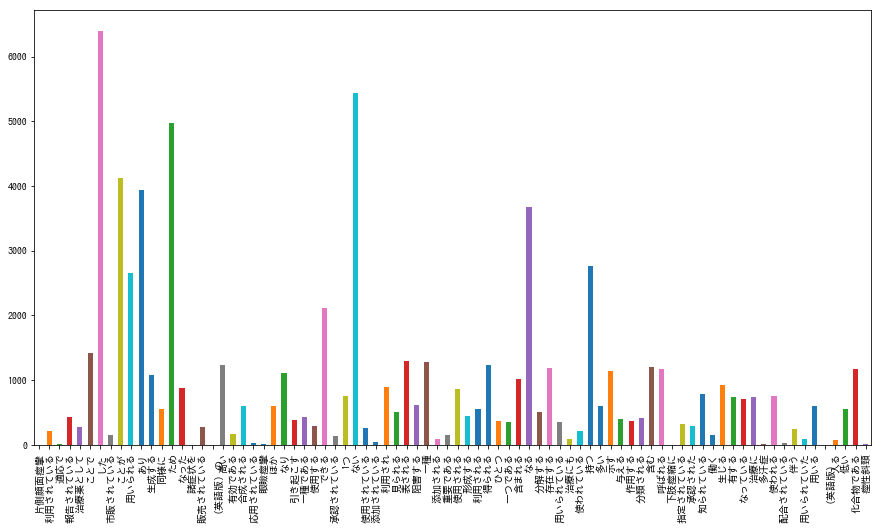

In [43]:
feature_word_dict = {}
for word in clue_words:
    feature_word_dict[word] = wiki_text_df.sentence.str.contains(fr'{word}'.replace(")", "\)").replace("(", "\(")).tolist()

pd.DataFrame(feature_word_dict).T.apply(lambda x: sum(x), axis=1).plot(kind='bar', figsize=(15, 8))

In [47]:
category = pd.read_csv("../data/category_list.csv")

In [53]:
category.loc[category.category.isin(noun_list)].to_csv("../data/category_in_noun_list.csv", index=False)